In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular

import tornadox
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import pof
from pof.main import (
    make_continuous_models,
    discretize_transitions,
    get_initial_trajectory,
    linearize_observation_model,
    get_x0,
)
from pof.ieks import filtsmooth, smoothing
from pof.solve import solve_diffrax
from pof.utils import tria
from pof.ivp import lotkavolterra

In [3]:
order = 4
dt = 1e-2

First define the IVP and compute a reference solution with diffrax

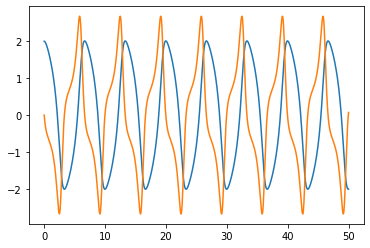

In [48]:
# ivp = lotkavolterra()
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0, tmax=50)
#ylims = (-1, 9)
# ylims = (-1, 1)

ts_true, ys_true, sol_true = solve_diffrax(ivp, rtol=1e-10, atol=1e-10)
plt.plot(ts_true, ys_true)
#plt.ylim(*ylims)

We now want to solve it with a time-parallel IEKS.

# Solving IVPs with the IEKS
We already did this in previous notebooks, but now the structure is a bit different: first create a continuous model, then discretize it, and then run a linear filter/smoother on that.

In [49]:
# for the initial guess, use Taylor-mode autodiff as usual via tornadox
x0 = get_x0(ivp, order)

# define the time grid
ts = jnp.arange(0, ivp.tmax + dt, dt)
# make a constant initial trajectory from y0
traj = get_initial_trajectory(ivp.y0, ivp.f, order, len(ts))
traj = jnp.repeat(x0.mean.reshape(1, -1), traj.shape[0], axis=0)

# make the continuous transition and observation models
iwp, om = make_continuous_models(ivp, order)
E0 = pof.transitions.projection_matrix(iwp, 0)

# make the discrete transition and observation model
dtm = discretize_transitions(iwp, ts)
lom = jax.jit(linearize_observation_model, static_argnums=0)
dom = lom(om, traj[1:])

In [50]:
%%time
#fs = jax.jit(filtsmooth)
fs = filtsmooth

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 13.8 µs


CPU times: user 2min 22s, sys: 30.3 s, total: 2min 52s
Wall time: 2min 17s


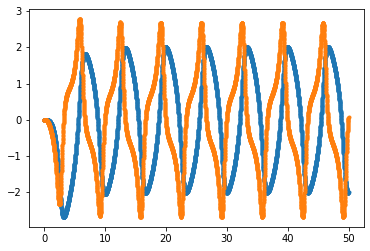

In [51]:
%%time
out, _, _ = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
#plt.plot(ts, ys, marker=".")
plt.plot(ts, (jax.vmap(sol_true.evaluate)(ts) - ys), marker=".")
#plt.ylim(*ylims)

Make GIF

In [52]:
@jax.jit
def stddev(chol, E0):
    _A = jnp.dot(E0, chol)
    C0 = jnp.dot(_A, _A.T)
    return jnp.sqrt(C0.diagonal())

In [53]:
_ys = jax.vmap(sol_true.evaluate)(ts)

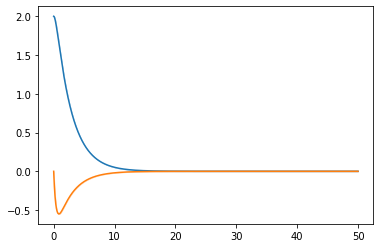

In [54]:
def _plot(out):
    ys = jnp.dot(E0, out.mean.T).T
    
    stds = jax.vmap(stddev, in_axes=(0, None))(out.chol, E0)
    for i in range(ys.shape[1]):
        plt.plot(ts, ys[:, i], color=f"C{i}")
        plt.fill_between(ts, ys[:, i] - 3 * stds[:, i], ys[:, i] + 3 * stds[:, i], alpha=0.2, color=f"C{i}")  


_plot(out)

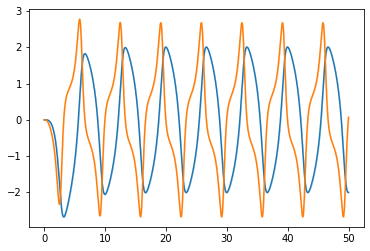

In [55]:
def _plot_e(out):
    ys = jnp.dot(E0, out.mean.T).T
    es = _ys - ys

    stds = jax.vmap(stddev, in_axes=(0, None))(out.chol, E0)
    for i in range(ys.shape[1]):
        plt.plot(ts, es[:, i], color=f"C{i}")
        plt.fill_between(ts, es[:, i] - 3 * stds[:, i], es[:, i] + 3 * stds[:, i], alpha=0.2, color=f"C{i}")  


_plot_e(out)

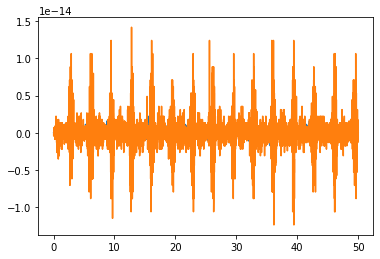

In [88]:
def _plot_i(out):
    dom = lom(om, out.mean[1:])    
    zs = jax.vmap(lambda x, H, b: H @ x + b)(out.mean[1:], dom.H, dom.b)
    for i in range(zs.shape[1]):
        plt.plot(ts[1:], zs[:, i], color=f"C{i}")

_plot_i(out)

  0%|          | 0/99 [00:00<?, ?it/s]

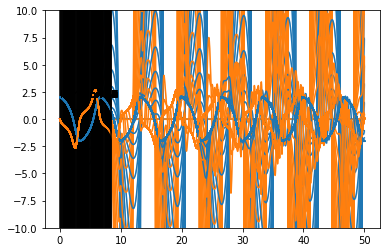

In [105]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

dom = lom(om, traj[1:])
out, _, _ = fs(x0, dtm, dom)
#_plot_i(out)
#plt.ylim(-1e-13, 1e-13)
_plot(out)
plt.ylim(-10, 10)
camera.snap()

for i in trange(1, 100):
    dom = lom(om, out.mean[1:])
    out, _, _ = fs(x0, dtm, dom)
    #_plot_i(out)
    #plt.ylim(-1e-13, 1e-13); plt.text(0, 5e-14, f"Iteration {i}")
    _plot(out)
    plt.ylim(-10, 10); plt.text(0, 2, f"Iteration {i}")
    plt.vlines([dt*i * jnp.log(len(ts))], ymin=-10, ymax=10, color="black")
    camera.snap()

animation = camera.animate()

In [106]:
animation.save('animation.gif')

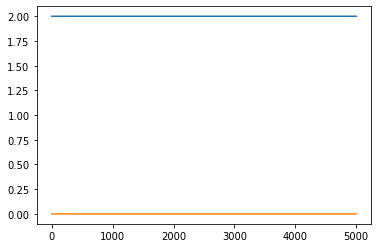

In [65]:
plt.plot(traj[1:, ::order+1])

(-10.0, 10.0)

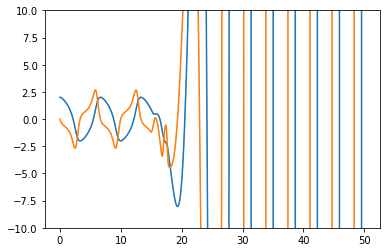

In [82]:
dom = lom(om, out.mean[1:])
out, _, _ = fs(x0, dtm, dom)
#_plot_i(dom, out)
_plot(out)
plt.ylim(-10, 10)